In [1]:
# Check if CUDA

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA not detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU count: 1
GPU name: NVIDIA GeForce RTX 2060
GPU memory: 6.0 GB


In [ ]:
# Complete ResNet-18 Ensemble Training, Analysis, and Visualization Pipeline

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import random
import json
import os
import glob
import pickle
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

try:
    from torch.cuda.amp import autocast, GradScaler
    MIXED_PRECISION_AVAILABLE = True
except ImportError:
    MIXED_PRECISION_AVAILABLE = False
    class autocast:
        def __enter__(self):
            return self
        def __exit__(self, *args):
            pass

def load_original_data():
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        age_counts = Counter(ages_grouped)
        valid_ages = {age for age, count in age_counts.items() if count >= 3}
        
        filtered_images = []
        filtered_ages = []
        
        for img, age in zip(images, ages_grouped):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
        
        return np.array(filtered_images), filtered_ages
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def enhanced_augment_image(image):
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    
    if random.random() < 0.7:
        angle = random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))
    
    if random.random() < 0.5:
        image = cv2.flip(image, 1)
    
    if random.random() < 0.8:
        alpha = random.uniform(0.7, 1.3)
        beta = random.randint(-25, 25)
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    if random.random() < 0.4:
        gamma = random.uniform(0.8, 1.2)
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = cv2.LUT(image, table)
    
    if random.random() < 0.3:
        noise = np.random.normal(0, 7, image.shape).astype(np.int16)
        image_int16 = image.astype(np.int16)
        noisy_image = np.clip(image_int16 + noise, 0, 255)
        image = noisy_image.astype(np.uint8)
    
    return image

def create_augmented_data(X_train, y_train, multiplier=25):
    class_counts = Counter(y_train)
    max_count = max(class_counts.values())
    target_count = max_count * multiplier
    
    X_aug = []
    y_aug = []
    
    for class_idx in range(len(set(y_train))):
        class_mask = y_train == class_idx
        class_images = X_train[class_mask]
        current_count = len(class_images)
        
        if current_count == 0:
            continue
        
        for _ in range(4):
            X_aug.extend(class_images)
            y_aug.extend([class_idx] * current_count)
        
        needed = target_count - (current_count * 4)
        for i in range(needed):
            orig_idx = random.randint(0, current_count - 1)
            aug_img = enhanced_augment_image(class_images[orig_idx].copy())
            X_aug.append(aug_img)
            y_aug.append(class_idx)
    
    return np.array(X_aug), np.array(y_aug)

class OptimizedDataset(Dataset):
    def __init__(self, X, y, test_time_aug=False):
        self.X = torch.FloatTensor(X if isinstance(X, np.ndarray) else np.array(X))
        self.y = torch.LongTensor(y if isinstance(y, np.ndarray) else np.array(y))
        self.test_time_aug = test_time_aug
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx].clone()
        label = self.y[idx].clone()
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), mode='bilinear', align_corners=False).squeeze(0)
        
        if self.test_time_aug and random.random() < 0.5:
            image = torch.flip(image, [2])
        
        image = (image - self.mean) / self.std
        return image, label

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        handle1 = self.target_layer.register_forward_hook(self.forward_hook)
        handle2 = self.target_layer.register_backward_hook(self.backward_hook)
        self.handles.extend([handle1, handle2])
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def generate_cam(self, input_image, class_idx):
        self.model.eval()
        
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)
        
        input_image.requires_grad_()
        output = self.model(input_image)
        
        self.model.zero_grad()
        
        class_score = output[:, class_idx]
        class_score.backward()
        
        if self.gradients is None or self.activations is None:
            return np.zeros((224, 448))
        
        gradients = self.gradients[0].to(device)
        activations = self.activations[0].to(device)
        
        weights = torch.mean(gradients, dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

class ResNet18EnsembleTrainer:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        if torch.cuda.is_available():
            torch.backends.cudnn.benchmark = True
            if MIXED_PRECISION_AVAILABLE:
                self.scaler = GradScaler()
                self.use_amp = True
            else:
                self.use_amp = False
        else:
            self.use_amp = False
    
    def create_resnet18_model(self):
        model = timm.create_model('resnet18', pretrained=True, num_classes=self.num_classes)
        
        frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
        for name, param in model.named_parameters():
            for frozen_layer in frozen_layers:
                if name.startswith(frozen_layer):
                    param.requires_grad = False
                    break
        
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, self.num_classes)
        )
        
        return model.to(self.device)
    
    def train_single_fold(self, train_loader, val_loader, fold_idx):
        model = self.create_resnet18_model()
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'fc' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 0.0003},
            {'params': classifier_params, 'lr': 0.001}
        ], weight_decay=0.03)
        
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-6)
        
        max_epochs = 80
        patience = 20
        best_val_acc = 0.0
        patience_counter = 0
        best_state = None
        
        # Track training history
        training_history = {
            'train_accs': [],
            'val_accs': [],
            'train_losses': [],
            'val_losses': []
        }
        
        for epoch in range(max_epochs):
            model.train()
            train_correct = 0
            train_total = 0
            train_loss_total = 0.0
            train_batches = 0
            
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                
                if self.use_amp:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    self.scaler.scale(loss).backward()
                    self.scaler.step(optimizer)
                    self.scaler.update()
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                train_loss_total += loss.item()
                train_batches += 1
            
            train_acc = 100 * train_correct / train_total
            train_loss = train_loss_total / train_batches
            
            model.eval()
            val_correct = 0
            val_total = 0
            val_loss_total = 0.0
            val_batches = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    if self.use_amp:
                        with autocast():
                            outputs = model(images)
                            loss = criterion(outputs, labels)
                    else:
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss_total += loss.item()
                    val_batches += 1
            
            val_acc = 100 * val_correct / val_total
            val_loss = val_loss_total / val_batches
            scheduler.step()
            
            # Record training history
            training_history['train_accs'].append(train_acc)
            training_history['val_accs'].append(val_acc)
            training_history['train_losses'].append(train_loss)
            training_history['val_losses'].append(val_loss)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_state = model.state_dict().copy()
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                break
            
            # Periodic GPU memory cleanup
            if epoch % 10 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        if best_state is not None:
            model.load_state_dict(best_state)
        
        return model, best_val_acc, training_history
    
    def train_ensemble(self, images, ages):
        if not isinstance(images, np.ndarray):
            images = np.array(images)
        if not isinstance(ages, np.ndarray):
            ages = np.array(ages)
        
        unique_ages = sorted(list(set(ages)))
        label_mapping = {age: i for i, age in enumerate(unique_ages)}
        y_indices = np.array([label_mapping[age] for age in ages])
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        trained_models = []
        cv_scores = []
        training_histories = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(images, y_indices)):
            X_train_fold = images[train_idx]
            y_train_fold = y_indices[train_idx]
            X_val_fold = images[val_idx]
            y_val_fold = y_indices[val_idx]
            
            X_train_aug, y_train_aug = create_augmented_data(X_train_fold, y_train_fold, multiplier=25)
            
            train_dataset = OptimizedDataset(X_train_aug, y_train_aug)
            val_dataset = OptimizedDataset(X_val_fold, y_val_fold, test_time_aug=True)
            
            batch_size = 32 if torch.cuda.is_available() else 8
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
            
            model, val_acc, history = self.train_single_fold(train_loader, val_loader, fold + 1)
            
            trained_models.append(model)
            cv_scores.append(val_acc)
            training_histories.append(history)
            print(f"Fold {fold + 1}/5 completed: {val_acc:.1f}% validation accuracy")
            
            # Clear GPU memory after each fold
            torch.cuda.empty_cache()
            
            torch.cuda.empty_cache()
        
        return trained_models, cv_scores, label_mapping, training_histories
    
    def evaluate_model_with_tta(self, model, test_loader):
        model.eval()
        all_predictions = []
        all_probabilities = []
        all_labels = []
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs1 = model(images)
                flipped = torch.flip(images, [3])
                outputs2 = model(flipped)
                
                avg_outputs = (outputs1 + outputs2) / 2
                probs = F.softmax(avg_outputs, dim=1)
                _, predicted = torch.max(avg_outputs, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = 100 * correct / total
        return accuracy, all_predictions, all_probabilities, all_labels
    
    def evaluate_ensemble(self, models, cv_scores, test_loader):
        scores_array = np.array(cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        for model in models:
            model.eval()
        
        test_correct = 0
        test_total = 0
        all_ensemble_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                ensemble_outputs = torch.zeros(images.size(0), self.num_classes).to(self.device)
                
                for model, weight in zip(models, weights):
                    outputs1 = model(images)
                    flipped = torch.flip(images, [3])
                    outputs2 = model(flipped)
                    avg_outputs = (outputs1 + outputs2) / 2
                    
                    ensemble_outputs += weight * F.softmax(avg_outputs, dim=1)
                
                _, predicted = torch.max(ensemble_outputs, 1)
                
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
                all_ensemble_probs.extend(ensemble_outputs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        ensemble_acc = 100 * test_correct / test_total
        
        return ensemble_acc, np.array(all_ensemble_probs), np.array(all_labels)

class ModelAnalyzer:
    def __init__(self, models, cv_scores, label_mapping, X_test, y_test, training_histories):
        self.models = models
        self.cv_scores = cv_scores
        self.label_mapping = label_mapping
        self.X_test = X_test
        self.y_test = y_test
        self.training_histories = training_histories
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.unique_ages = sorted(list(label_mapping.keys()))
        self.num_classes = len(self.unique_ages)
        
        Path("analysis_plots").mkdir(exist_ok=True)
    
    def evaluate_individual_models(self):
        test_dataset = OptimizedDataset(self.X_test, self.y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        trainer = ResNet18EnsembleTrainer(self.num_classes)
        individual_results = []
        
        for i, model in enumerate(self.models):
            accuracy, preds, probs, labels = trainer.evaluate_model_with_tta(model, test_loader)
            
            individual_results.append({
                'model_name': f'ResNet18_Fold_{i+1}',
                'accuracy': accuracy,
                'cv_score': self.cv_scores[i],
                'predictions': np.array(preds),
                'probabilities': np.array(probs),
                'true_labels': np.array(labels)
            })
        
        return individual_results
    
    def evaluate_ensemble(self, individual_results):
        test_dataset = OptimizedDataset(self.X_test, self.y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        trainer = ResNet18EnsembleTrainer(self.num_classes)
        ensemble_acc, ensemble_probs, true_labels = trainer.evaluate_ensemble(self.models, self.cv_scores, test_loader)
        
        ensemble_preds = np.argmax(ensemble_probs, axis=1)
        
        return {
            'ensemble_accuracy': ensemble_acc,
            'ensemble_predictions': ensemble_preds,
            'ensemble_probabilities': ensemble_probs,
            'true_labels': true_labels
        }
    
    def calculate_metrics(self, individual_results, ensemble_result):
        metrics = {}
        
        for i, result in enumerate(individual_results):
            preds = result['predictions']
            true_labels = result['true_labels']
            
            accuracy = np.mean(preds == true_labels) * 100
            f1_macro = f1_score(true_labels, preds, average='macro', zero_division=0) * 100
            f1_weighted = f1_score(true_labels, preds, average='weighted', zero_division=0) * 100
            precision = precision_score(true_labels, preds, average='macro', zero_division=0) * 100
            recall = recall_score(true_labels, preds, average='macro', zero_division=0) * 100
            
            metrics[f'model_{i+1}'] = {
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'precision': precision,
                'recall': recall,
                'cv_score': result['cv_score']
            }
        
        if ensemble_result:
            ensemble_preds = ensemble_result['ensemble_predictions']
            true_labels = ensemble_result['true_labels']
            
            ensemble_accuracy = np.mean(ensemble_preds == true_labels) * 100
            ensemble_f1_macro = f1_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_f1_weighted = f1_score(true_labels, ensemble_preds, average='weighted', zero_division=0) * 100
            ensemble_precision = precision_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            ensemble_recall = recall_score(true_labels, ensemble_preds, average='macro', zero_division=0) * 100
            
            metrics['ensemble'] = {
                'accuracy': ensemble_accuracy,
                'f1_macro': ensemble_f1_macro,
                'f1_weighted': ensemble_f1_weighted,
                'precision': ensemble_precision,
                'recall': ensemble_recall
            }
            
            class_names = [f'Age {age}' for age in self.unique_ages]
            metrics['classification_report'] = classification_report(
                true_labels, ensemble_preds,
                output_dict=True,
                zero_division=0
            )
            metrics['class_names'] = class_names
        
        return metrics
    
    def create_performance_plots(self, individual_results, ensemble_result, metrics):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        model_names = [f'Fold {i+1}' for i in range(len(individual_results))]
        accuracies = [result['accuracy'] for result in individual_results]
        cv_scores = [result['cv_score'] for result in individual_results]
        
        if ensemble_result:
            model_names.append('Ensemble')
            accuracies.append(ensemble_result['ensemble_accuracy'])
            cv_scores.append(np.mean(cv_scores))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        
        bars = ax1.bar(model_names, accuracies, alpha=0.8, color=colors, edgecolor='black', linewidth=2)
        ax1.axhline(y=70, color='red', linestyle='--', linewidth=2, label="Target: 70%")
        
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        ax1.set_ylabel('Test Accuracy (%)')
        ax1.set_title('Model Performance Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # CV vs Test comparison
        test_accs = [result['accuracy'] for result in individual_results]
        cv_accs = [result['cv_score'] for result in individual_results]
        
        ax2.scatter(cv_accs, test_accs, alpha=0.7, s=100, c=colors[:-1] if ensemble_result else colors)
        
        min_acc = min(min(cv_accs), min(test_accs)) - 5
        max_acc = max(max(cv_accs), max(test_accs)) + 5
        ax2.plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.5)
        
        ax2.set_xlabel('Cross-Validation Accuracy (%)')
        ax2.set_ylabel('Test Accuracy (%)')
        ax2.set_title('CV vs Test Performance')
        ax2.grid(True, alpha=0.3)
        
        # F1 Scores
        f1_scores = [metrics[f'model_{i+1}']['f1_macro'] for i in range(len(individual_results))]
        if ensemble_result and 'ensemble' in metrics:
            f1_scores.append(metrics['ensemble']['f1_macro'])
        
        ax3.bar(model_names, f1_scores, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        ax3.set_ylabel('F1 Score (%)')
        ax3.set_title('F1 Score (Macro) Comparison')
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)
        
        # Class distribution
        if ensemble_result:
            true_labels = ensemble_result['true_labels']
            ensemble_preds = ensemble_result['ensemble_predictions']
            class_names = [f'Age {age}' for age in self.unique_ages]
            
            true_dist = [np.sum(true_labels == i) for i in range(len(class_names))]
            pred_dist = [np.sum(ensemble_preds == i) for i in range(len(class_names))]
            
            x = np.arange(len(class_names))
            width = 0.35
            
            ax4.bar(x - width/2, true_dist, width, label='True Distribution', alpha=0.7, color='skyblue')
            ax4.bar(x + width/2, pred_dist, width, label='Predicted Distribution', alpha=0.7, color='salmon')
            
            ax4.set_xlabel('Age Class')
            ax4.set_ylabel('Number of Samples')
            ax4.set_title('True vs Predicted Distribution')
            ax4.set_xticks(x)
            ax4.set_xticklabels(class_names)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('analysis_plots/performance_overview.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_confusion_matrix(self, ensemble_result):
        if not ensemble_result:
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        true_labels = ensemble_result['true_labels']
        ensemble_preds = ensemble_result['ensemble_predictions']
        class_names = [f'Age {age}' for age in self.unique_ages]
        
        cm = confusion_matrix(true_labels, ensemble_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Number of Samples'})
        ax1.set_title('Confusion Matrix (Counts)')
        ax1.set_xlabel('Predicted Age Class')
        ax1.set_ylabel('True Age Class')
        
        cm_norm = confusion_matrix(true_labels, ensemble_preds, normalize='true')
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax2,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'label': 'Proportion'})
        ax2.set_title('Confusion Matrix (Normalized)')
        ax2.set_xlabel('Predicted Age Class')
        ax2.set_ylabel('True Age Class')
        
        plt.tight_layout()
        plt.savefig('analysis_plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_training_curves(self):
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        for fold, history in enumerate(self.training_histories):
            ax = axes[fold]
            epochs = range(1, len(history['train_accs']) + 1)
            
            ax.plot(epochs, history['train_accs'], 'b-', label='Training', linewidth=2, alpha=0.8)
            ax.plot(epochs, history['val_accs'], 'r-', label='Validation', linewidth=2, alpha=0.8)
            
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Accuracy (%)')
            ax.set_title(f'Fold {fold + 1} Training Curves')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('analysis_plots/training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_analysis(self):
        individual_results = self.evaluate_individual_models()
        ensemble_result = self.evaluate_ensemble(individual_results)
        metrics = self.calculate_metrics(individual_results, ensemble_result)
        
        self.create_performance_plots(individual_results, ensemble_result, metrics)
        self.create_confusion_matrix(ensemble_result)
        self.create_training_curves()
        
        return individual_results, ensemble_result, metrics

class GradCAMVisualizer:
    def __init__(self, models, label_mapping, X_test, y_test):
        self.models = models
        self.label_mapping = label_mapping
        self.X_test = X_test
        self.y_test = y_test
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.unique_ages = sorted(list(label_mapping.keys()))
        self.num_classes = len(self.unique_ages)
        
        Path("gradcam_visualizations").mkdir(exist_ok=True)
    
    def preprocess_image(self, image):
        if isinstance(image, np.ndarray):
            image = torch.FloatTensor(image)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), 
                                mode='bilinear', align_corners=False).squeeze(0)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)
    
    def overlay_heatmap(self, image, heatmap, alpha=0.6):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0
        
        if image.max() <= 1.0:
            image_display = image
        else:
            image_display = image.astype(np.float32) / 255.0
        
        overlaid = alpha * heatmap_colored + (1 - alpha) * image_display
        return overlaid
    
    def select_diverse_samples(self, num_samples):
        selected_indices = []
        
        for class_idx in range(self.num_classes):
            class_indices = np.where(np.array(self.y_test) == class_idx)[0]
            if len(class_indices) > 0:
                selected_indices.append(np.random.choice(class_indices))
        
        remaining_needed = num_samples - len(selected_indices)
        if remaining_needed > 0:
            available_indices = [i for i in range(len(self.y_test)) if i not in selected_indices]
            additional = np.random.choice(available_indices, 
                                        min(remaining_needed, len(available_indices)), 
                                        replace=False)
            selected_indices.extend(additional)
        
        return selected_indices[:num_samples]
    
    def visualize_model_attention(self, num_samples=6):
        sample_indices = self.select_diverse_samples(num_samples)
        
        num_cols = 2 + len(self.models)
        fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))
        
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        grad_cams = []
        
        for i, model in enumerate(self.models):
            try:
                target_layer = model.layer4[-1].conv2
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
            except Exception as e:
                grad_cams.append(None)
        
        try:
            for sample_idx, idx in enumerate(sample_indices):
                original_image = self.X_test[idx]
                true_label = self.y_test[idx]
                true_age = self.unique_ages[true_label]
                
                input_tensor = self.preprocess_image(original_image.copy())
                
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[sample_idx, 0].imshow(display_image)
                axes[sample_idx, 0].set_title(f'Original\nTrue: Age {true_age}', fontsize=10)
                axes[sample_idx, 0].axis('off')
                
                model_heatmaps = []
                
                for model_idx, (model, grad_cam) in enumerate(zip(self.models, grad_cams)):
                    if grad_cam is None:
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Failed', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                        continue
                    
                    try:
                        with torch.no_grad():
                            model_output = model(input_tensor)
                            model_pred = torch.argmax(model_output, dim=1).item()
                        
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), model_pred)
                        model_heatmaps.append(heatmap)
                        
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        axes[sample_idx, model_idx + 1].imshow(overlaid)
                        axes[sample_idx, model_idx + 1].set_title(f'Fold {model_idx + 1}\nPred: Age {self.unique_ages[model_pred]}', fontsize=9)
                        axes[sample_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        axes[sample_idx, model_idx + 1].text(0.5, 0.5, 'Error', 
                                                           transform=axes[sample_idx, model_idx + 1].transAxes,
                                                           ha='center', va='center')
                        axes[sample_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                
                # Create ensemble heatmap
                valid_heatmaps = [h for h in model_heatmaps if h is not None]
                if valid_heatmaps:
                    ensemble_heatmap = np.mean(valid_heatmaps, axis=0)
                    ensemble_overlaid = self.overlay_heatmap(display_image, ensemble_heatmap)
                    
                    axes[sample_idx, -1].imshow(ensemble_overlaid)
                    axes[sample_idx, -1].set_title(f'Ensemble\nAverage', fontsize=10)
                    axes[sample_idx, -1].axis('off')
                else:
                    axes[sample_idx, -1].text(0.5, 0.5, 'No Valid\nHeatmaps', 
                                            transform=axes[sample_idx, -1].transAxes,
                                            ha='center', va='center')
                    axes[sample_idx, -1].axis('off')
                
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        finally:
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        plt.tight_layout()
        plt.savefig('gradcam_visualizations/resnet18_ensemble_attention.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    def run_gradcam_analysis(self):
        self.visualize_model_attention(num_samples=6)

def save_models_and_ensemble(models, cv_scores, label_mapping, ensemble_acc, training_histories):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = f"resnet18_ensemble_{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Save individual models
    for i, (model, score) in enumerate(zip(models, cv_scores)):
        model_path = os.path.join(save_dir, f"resnet18_fold_{i+1}_{score:.1f}pct.pth")
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_architecture': 'resnet18',
            'fold': i+1,
            'cv_score': score,
            'num_classes': len(label_mapping),
            'label_mapping': label_mapping,
            'input_size': (224, 448)
        }, model_path)
    
    # Save ensemble
    ensemble_path = os.path.join(save_dir, "resnet18_ensemble.pth")
    torch.save({
        'model_state_dicts': [model.state_dict() for model in models],
        'architectures_used': ['resnet18'] * len(models),
        'cv_scores': cv_scores,
        'ensemble_score': ensemble_acc,
        'num_classes': len(label_mapping),
        'label_mapping': label_mapping,
        'input_size': (224, 448)
    }, ensemble_path)
    
    # Save data splits and training histories
    with open(os.path.join(save_dir, "training_histories.pkl"), 'wb') as f:
        pickle.dump(training_histories, f)
    
    # Save metadata
    metadata = {
        'timestamp': timestamp,
        'architecture': 'resnet18',
        'num_folds': len(models),
        'cv_scores': cv_scores,
        'cv_mean': float(np.mean(cv_scores)),
        'cv_std': float(np.std(cv_scores)),
        'ensemble_score': ensemble_acc,
        'label_mapping': label_mapping,
        'input_size': '448x224'
    }
    
    with open(os.path.join(save_dir, "metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return save_dir

def main():
    print("ResNet-18 Ensemble Training, Analysis, and Visualization Pipeline")
    print("=" * 80)
    
    start_time = time.time()
    
    try:
        # Load data
        print("Loading data...")
        images, ages = load_original_data()
        
        # Create trainer
        trainer = ResNet18EnsembleTrainer(num_classes=len(set(ages)))
        
        # Train ensemble
        print("Training ensemble...")
        models, cv_scores, label_mapping, training_histories = trainer.train_ensemble(images, ages)
        
        # Create test set
        y_indices = np.array([label_mapping[age] for age in ages])
        X_train_all, X_test, y_train_all, y_test = train_test_split(
            images, y_indices, test_size=0.2, random_state=42, stratify=y_indices
        )
        
        # Evaluate ensemble
        test_dataset = OptimizedDataset(X_test, y_test, test_time_aug=True)
        batch_size = 32 if torch.cuda.is_available() else 8
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        ensemble_acc, _, _ = trainer.evaluate_ensemble(models, cv_scores, test_loader)
        
        # Save models
        print("Saving models...")
        save_dir = save_models_and_ensemble(models, cv_scores, label_mapping, ensemble_acc, training_histories)
        
        elapsed = (time.time() - start_time) / 60
        
        print("\nTraining Results:")
        print(f"CV Scores: {[f'{score:.1f}%' for score in cv_scores]}")
        print(f"CV Mean: {np.mean(cv_scores):.1f}% ± {np.std(cv_scores):.1f}%")
        print(f"Ensemble Test Accuracy: {ensemble_acc:.1f}%")
        print(f"Training Time: {elapsed:.1f} minutes")
        print(f"Models saved to: {save_dir}")
        
        # Run analysis
        print("\nRunning model analysis...")
        analyzer = ModelAnalyzer(models, cv_scores, label_mapping, X_test, y_test, training_histories)
        individual_results, ensemble_result, metrics = analyzer.run_analysis()
        
        # Run Grad-CAM visualization
        print("\nRunning Grad-CAM visualization...")
        gradcam_viz = GradCAMVisualizer(models, label_mapping, X_test, y_test)
        gradcam_viz.run_gradcam_analysis()
        
        print("\nPipeline Complete!")
        print("Check 'analysis_plots/' for performance analysis")
        print("Check 'gradcam_visualizations/' for attention maps")
        
        return {
            'models': models,
            'cv_scores': cv_scores,
            'ensemble_score': ensemble_acc,
            'save_directory': save_dir
        }
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

ResNet-18 Ensemble Training, Analysis, and Visualization Pipeline
Loading data...
Training ensemble...


Age Group Specific GradCAM Analysis
Age Group Specific GradCAM Analyzer
Device: cuda
Found ensemble directory: resnet18_ensemble_20250716_193626
Loading original data...
Processing 232 image files...
Age distribution: {0.5: 35, 2.5: 33, 3.5: 29, 1.5: 55, 4.5: 20, 5.5: 60}
Available age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
Loading trained ensemble...
Loaded fold 1 model: 80.9% CV accuracy
Loaded fold 2 model: 85.1% CV accuracy
Loaded fold 3 model: 91.3% CV accuracy
Loaded fold 4 model: 80.4% CV accuracy
Loaded fold 5 model: 84.8% CV accuracy
Loaded 5 models
Available age groups: [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
Age to index mapping: {0.5: 0, 1.5: 1, 2.5: 2, 3.5: 3, 4.5: 4, 5.5: 5}
Ready for age group GradCAM analysis

Starting Age Group GradCAM Analysis
Creating age group GradCAM visualization...
Selecting representative images:
  Age 0.5: bsd_0p5_000.png (index 0)
  Age 1.5: cpj_1p5_000.png (index 5)
  Age 2.5: bsd_2p5_000.png (index 2)
  Age 3.5: bsd_3p5_000.png (index 3)
  Age 4.5: c

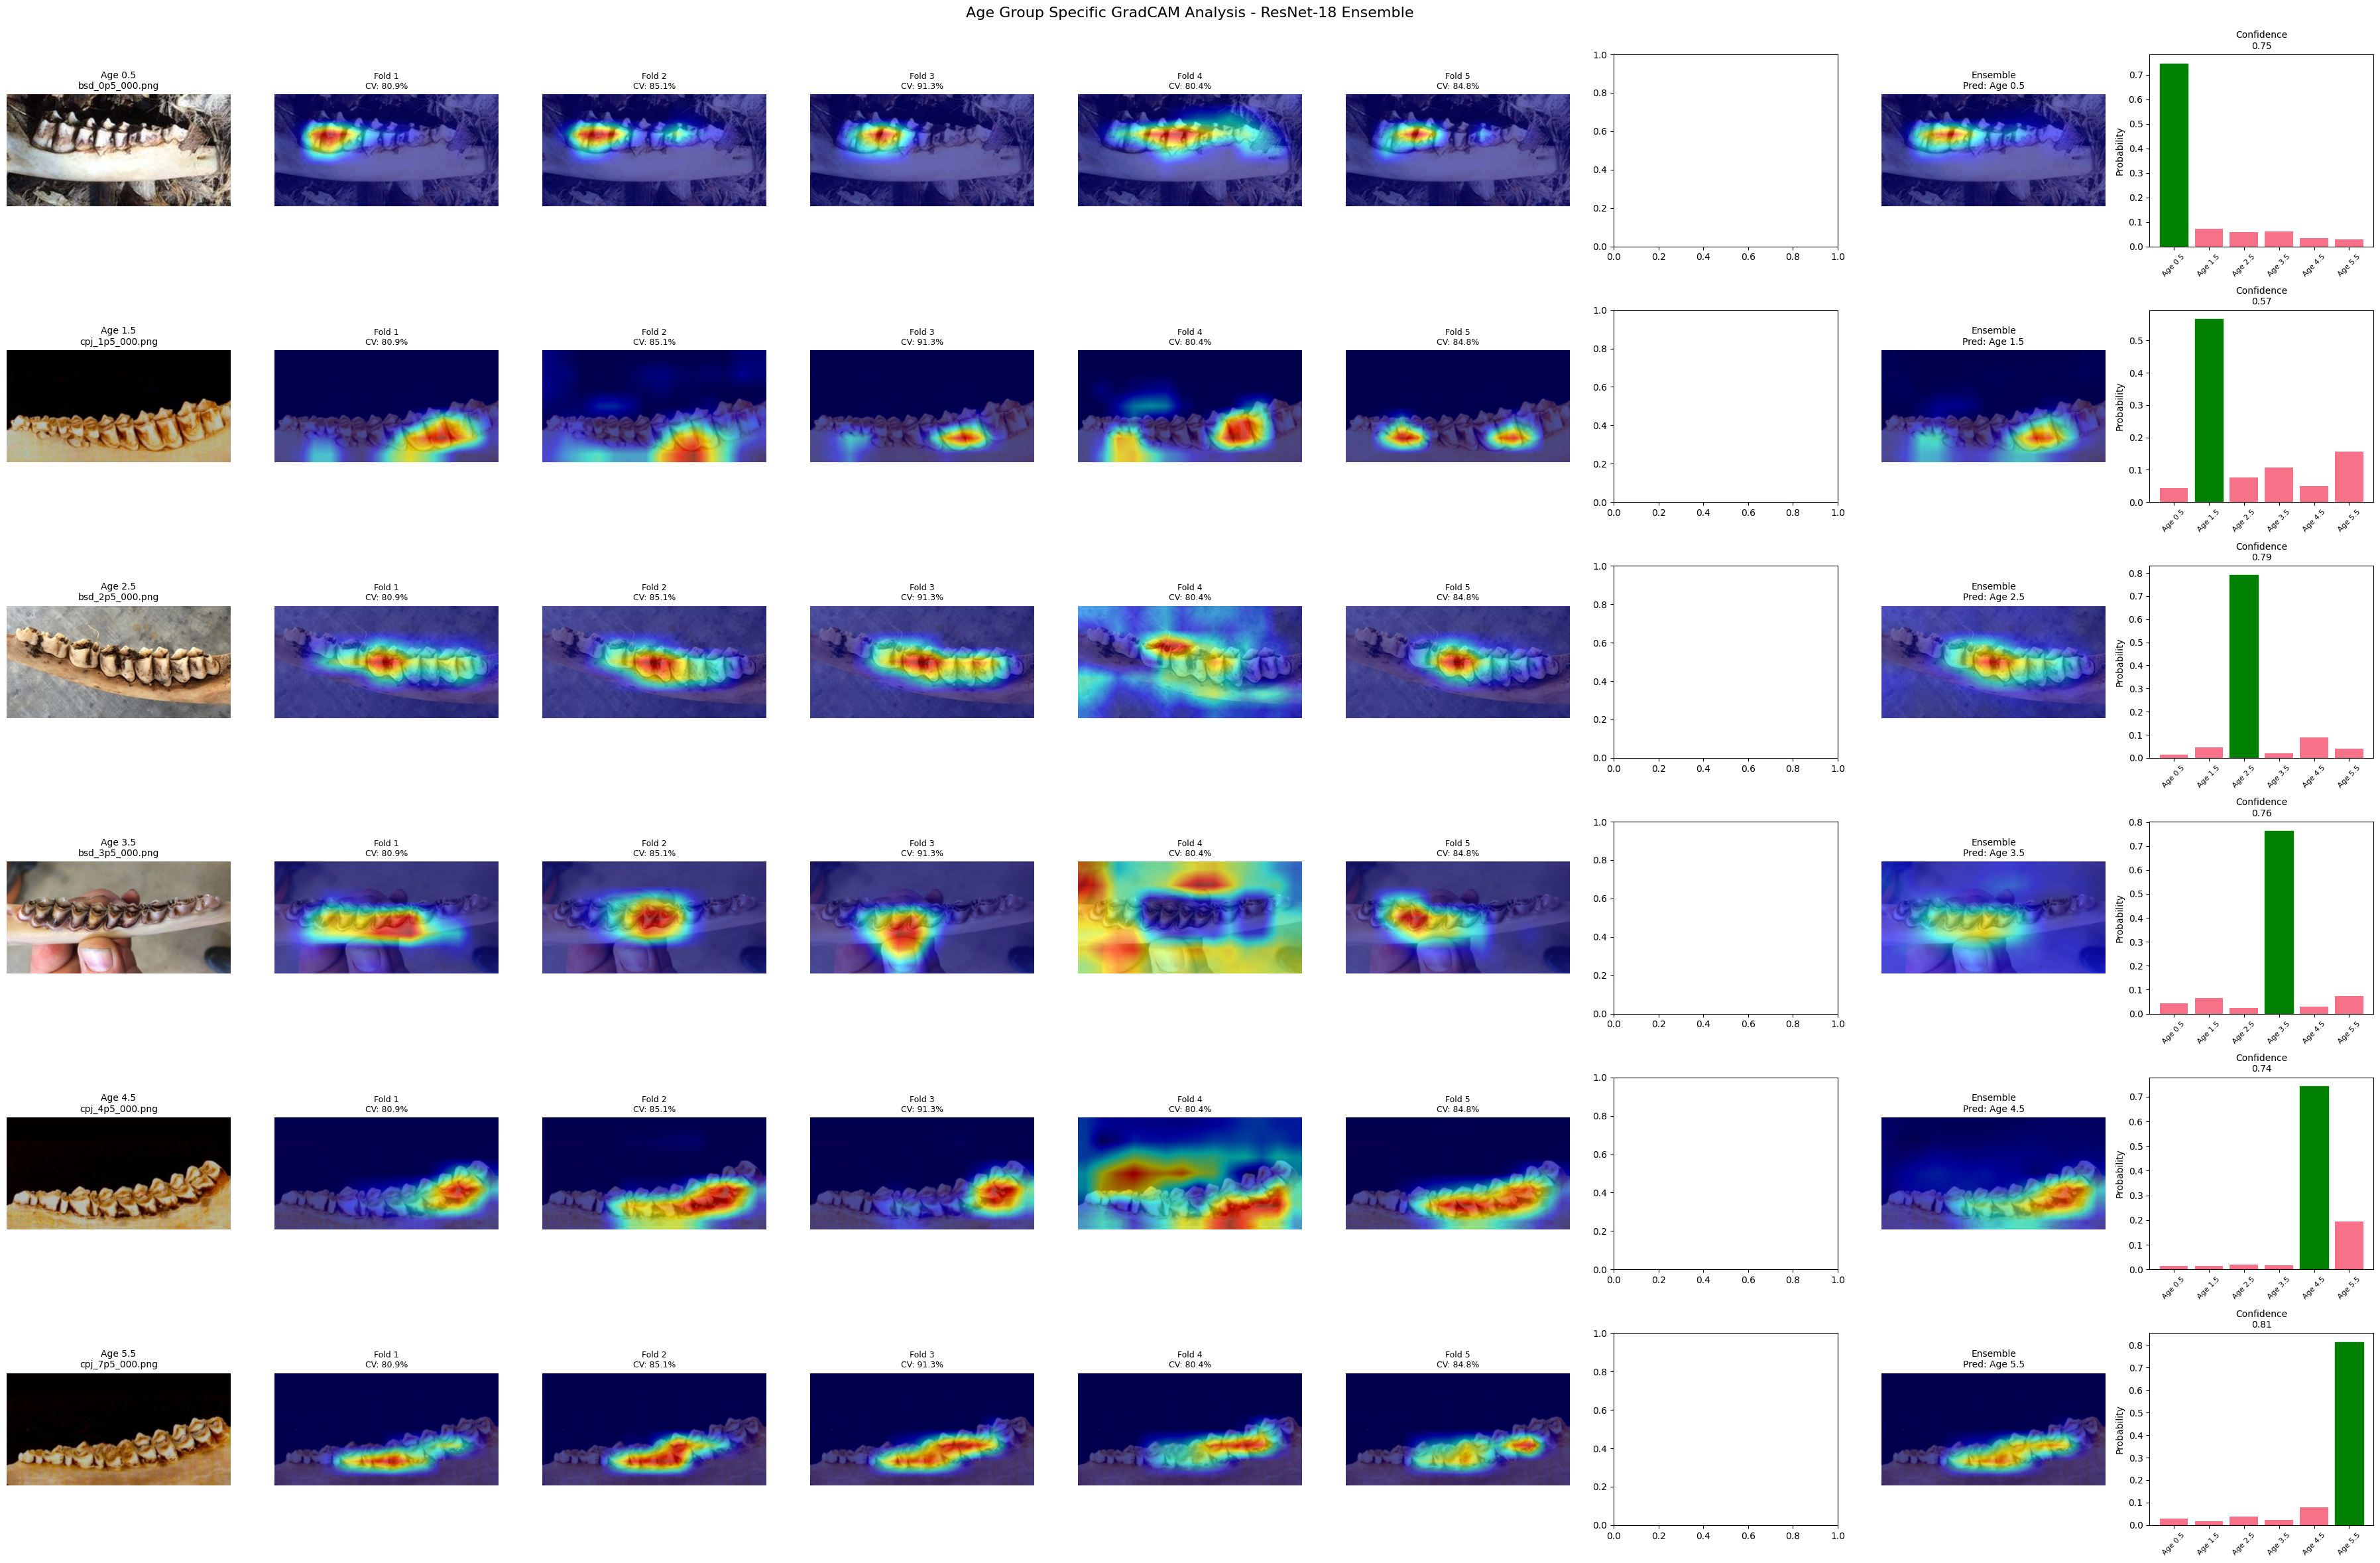

Age group GradCAM analysis saved to 'age_group_gradcam/age_group_analysis.png'

Analysis Summary:
Age 0.5: bsd_0p5_000.png
Age 1.5: cpj_1p5_000.png
Age 2.5: bsd_2p5_000.png
Age 3.5: bsd_3p5_000.png
Age 4.5: cpj_4p5_000.png
Age 5.5: cpj_7p5_000.png
Creating simplified age group comparison...
Selecting representative images:
  Age 0.5: bsd_0p5_000.png (index 0)
  Age 1.5: cpj_1p5_000.png (index 5)
  Age 2.5: bsd_2p5_000.png (index 2)
  Age 3.5: bsd_3p5_000.png (index 3)
  Age 4.5: cpj_4p5_000.png (index 9)
  Age 5.5: cpj_7p5_000.png (index 10)


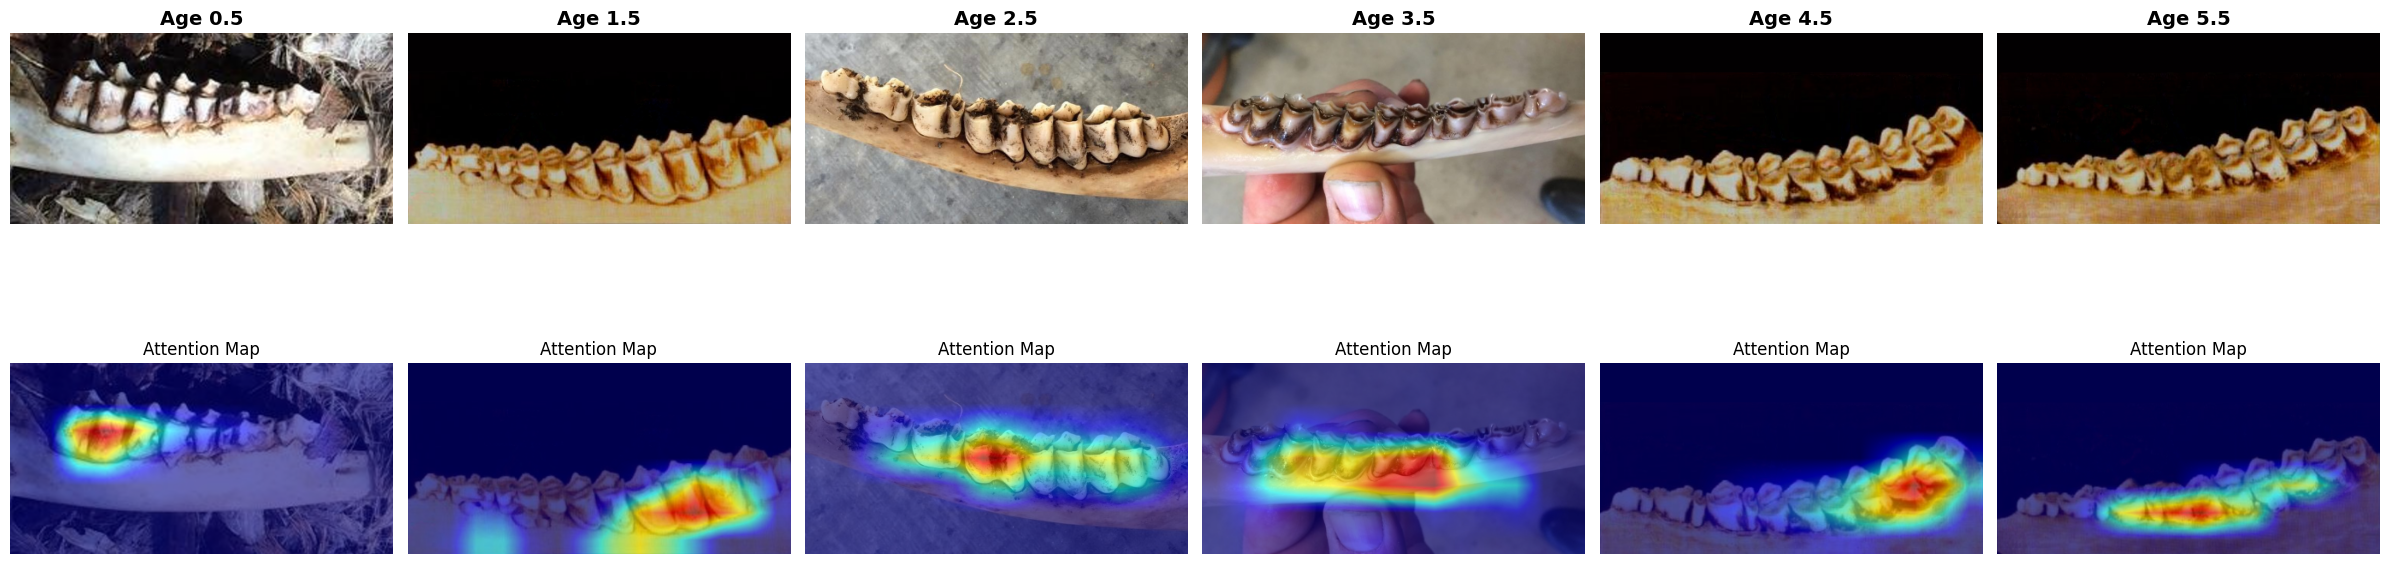

Simplified comparison saved to 'age_group_gradcam/simplified_age_comparison.png'

Age Group GradCAM Analysis Complete!
Generated files:
- age_group_gradcam/age_group_analysis.png: Comprehensive analysis
- age_group_gradcam/simplified_age_comparison.png: Simplified comparison


In [8]:
# Age Group Specific GradCAM Analysis Script
# Shows attention maps for one representative image from each age group

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import os
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

def load_original_data():
    """Load and process the original deer tooth images"""
    try:
        fpath = "G:\\Dropbox\\AI Projects\\buck\\tooth_analysis\\images\\*.png"
        
        image_paths = glob.glob(fpath)
        if not image_paths:
            raise FileNotFoundError(f"No images found at {fpath}")
        
        images = []
        ages = []
        filenames = []
        
        print(f"Processing {len(image_paths)} image files...")
        
        for img_path in image_paths:
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Convert BGR to RGB for correct color display
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, (448, 224))
                
                filename = os.path.basename(img_path)
                filename_no_ext = os.path.splitext(filename)[0]
                parts = filename_no_ext.split('_')
                
                if len(parts) < 3:
                    continue
                
                bbb_part = parts[1]
                
                if 'p' not in bbb_part:
                    continue
                
                value_str = bbb_part.replace('p', '.')
                try:
                    age_value = float(value_str)
                except ValueError:
                    continue
                
                images.append(img_resized)
                ages.append(age_value)
                filenames.append(filename)
                
            except Exception as e:
                continue
        
        if not images:
            raise ValueError("No valid images loaded")
        
        # Group ages: anything >= 5.5 becomes 5.5
        ages_grouped = [5.5 if age >= 5.5 else age for age in ages]
        
        # Filter out classes with too few samples
        age_counts = Counter(ages_grouped)
        print(f"Age distribution: {dict(age_counts)}")
        
        valid_ages = {age for age, count in age_counts.items() if count >= 1}  # At least 1 sample for visualization
        
        filtered_images = []
        filtered_ages = []
        filtered_filenames = []
        
        for img, age, filename in zip(images, ages_grouped, filenames):
            if age in valid_ages:
                filtered_images.append(img)
                filtered_ages.append(age)
                filtered_filenames.append(filename)
        
        print(f"Available age groups: {sorted(list(valid_ages))}")
        
        return np.array(filtered_images), filtered_ages, filtered_filenames
        
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def find_latest_ensemble_directory():
    """Find the most recent ResNet-18 ensemble directory"""
    patterns = ["resnet18_ensemble_*"]
    
    dirs = []
    for pattern in patterns:
        dirs.extend(glob.glob(pattern))
    
    if not dirs:
        raise FileNotFoundError("No ResNet-18 ensemble directories found! Please run the training script first.")
    
    latest_dir = max(dirs, key=os.path.getmtime)
    print(f"Found ensemble directory: {latest_dir}")
    return latest_dir

def load_trained_ensemble(ensemble_dir):
    """Load the trained ResNet-18 ensemble models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load metadata
    with open(os.path.join(ensemble_dir, "metadata.json"), 'r') as f:
        metadata = json.load(f)
    
    label_mapping = metadata['label_mapping']
    num_classes = len(label_mapping)
    
    # Load individual models
    models = []
    cv_scores = metadata['cv_scores']
    
    for fold in range(1, 6):  # 5 folds
        # Find model file for this fold
        model_files = glob.glob(os.path.join(ensemble_dir, f"resnet18_fold_{fold}_*.pth"))
        if not model_files:
            print(f"Warning: No model file found for fold {fold}")
            continue
        
        model_path = model_files[0]
        checkpoint = torch.load(model_path, map_location=device)
        
        # Create ResNet-18 model
        model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
        
        # Apply same modifications as training
        frozen_layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3']
        for name, param in model.named_parameters():
            for frozen_layer in frozen_layers:
                if name.startswith(frozen_layer):
                    param.requires_grad = False
                    break
        
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )
        
        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        model.eval()
        
        models.append(model)
        print(f"Loaded fold {fold} model: {cv_scores[fold-1]:.1f}% CV accuracy")
    
    return models, label_mapping, cv_scores

class GradCAM:
    """GradCAM implementation for ResNet-18"""
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.handles = []
        
        handle1 = self.target_layer.register_forward_hook(self.forward_hook)
        handle2 = self.target_layer.register_backward_hook(self.backward_hook)
        self.handles.extend([handle1, handle2])
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()
        self.handles = []
    
    def generate_cam(self, input_image, class_idx):
        self.model.eval()
        
        device = next(self.model.parameters()).device
        input_image = input_image.to(device)
        
        input_image.requires_grad_()
        output = self.model(input_image)
        
        self.model.zero_grad()
        
        class_score = output[:, class_idx]
        class_score.backward()
        
        if self.gradients is None or self.activations is None:
            return np.zeros((224, 448))
        
        gradients = self.gradients[0].to(device)
        activations = self.activations[0].to(device)
        
        weights = torch.mean(gradients, dim=(1, 2))
        
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

class AgeGroupGradCAMAnalyzer:
    """Analyzer for age group specific GradCAM visualization"""
    
    def __init__(self, ensemble_dir=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        print("Age Group Specific GradCAM Analyzer")
        print("=" * 50)
        print(f"Device: {self.device}")
        
        # Find ensemble directory if not provided
        if ensemble_dir is None:
            ensemble_dir = find_latest_ensemble_directory()
        
        self.ensemble_dir = ensemble_dir
        
        # Load data and models
        self.load_data_and_models()
        
        # Create output directory
        Path("age_group_gradcam").mkdir(exist_ok=True)
        
        print("Ready for age group GradCAM analysis")
    
    def load_data_and_models(self):
        """Load original data and trained models"""
        print("Loading original data...")
        self.images, self.ages, self.filenames = load_original_data()
        
        print("Loading trained ensemble...")
        self.models, self.label_mapping, self.cv_scores = load_trained_ensemble(self.ensemble_dir)
        
        # Create reverse mapping for age indices - ensure consistency
        # Convert string keys to floats for consistency with loaded data
        self.age_to_idx = {}
        self.idx_to_age = {}
        
        for age_str, idx in self.label_mapping.items():
            age_float = float(age_str)
            self.age_to_idx[age_float] = idx
            self.idx_to_age[idx] = age_float
        
        self.unique_ages = sorted(list(self.age_to_idx.keys()))
        self.num_classes = len(self.unique_ages)
        
        print(f"Loaded {len(self.models)} models")
        print(f"Available age groups: {self.unique_ages}")
        print(f"Age to index mapping: {self.age_to_idx}")
    
    def preprocess_image(self, image):
        """Preprocess image for model input"""
        if isinstance(image, np.ndarray):
            image = torch.FloatTensor(image)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
        
        if image.shape[-2:] != (224, 448):
            image = F.interpolate(image.unsqueeze(0), size=(224, 448), 
                                mode='bilinear', align_corners=False).squeeze(0)
        
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = (image - mean) / std
        
        return image.unsqueeze(0).to(self.device)
    
    def overlay_heatmap(self, image, heatmap, alpha=0.6):
        """Overlay heatmap on original image"""
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8), 
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = heatmap_colored.astype(np.float32) / 255.0
        
        if image.max() <= 1.0:
            image_display = image
        else:
            image_display = image.astype(np.float32) / 255.0
        
        overlaid = alpha * heatmap_colored + (1 - alpha) * image_display
        return overlaid
    
    def select_representative_images(self):
        """Select one representative image from each age group"""
        target_ages = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
        selected_samples = {}
        
        # Group images by age
        age_groups = {}
        for i, age in enumerate(self.ages):
            if age not in age_groups:
                age_groups[age] = []
            age_groups[age].append(i)
        
        print("Selecting representative images:")
        
        # Select one image from each target age group if available
        for target_age in target_ages:
            if target_age in age_groups:
                # Choose the first image from this age group (could be randomized)
                idx = age_groups[target_age][0]
                selected_samples[target_age] = {
                    'index': idx,
                    'filename': self.filenames[idx],
                    'image': self.images[idx],
                    'age': self.ages[idx]
                }
                print(f"  Age {target_age}: {self.filenames[idx]} (index {idx})")
            else:
                print(f"  Age {target_age}: No images available")
        
        return selected_samples
    
    def get_ensemble_prediction(self, input_tensor):
        """Get ensemble prediction for an image"""
        # Use CV scores as weights
        scores_array = np.array(self.cv_scores)
        weights = np.exp(scores_array / 20)
        weights = weights / weights.sum()
        
        ensemble_probs = np.zeros(self.num_classes)
        
        for i, model in enumerate(self.models):
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
                ensemble_probs += weights[i] * probs
        
        predicted_class = np.argmax(ensemble_probs)
        confidence = ensemble_probs[predicted_class]
        
        return predicted_class, confidence, ensemble_probs
    
    def create_age_group_visualization(self):
        """Create comprehensive age group GradCAM visualization"""
        print("Creating age group GradCAM visualization...")
        
        selected_samples = self.select_representative_images()
        
        if not selected_samples:
            print("No representative images found!")
            return
        
        # Sort by age for consistent display
        sorted_ages = sorted(selected_samples.keys())
        num_ages = len(sorted_ages)
        
        # Create figure: ages x (original + models + ensemble + prediction)
        num_cols = 2 + len(self.models) + 2  # original + models + ensemble + prediction bars
        fig, axes = plt.subplots(num_ages, num_cols, figsize=(4*num_cols, 4*num_ages))
        
        if num_ages == 1:
            axes = axes.reshape(1, -1)
        
        # Initialize GradCAM for each model
        grad_cams = []
        for model in self.models:
            try:
                target_layer = model.layer4[-1].conv2  # Last conv layer in ResNet-18
                grad_cam = GradCAM(model, target_layer)
                grad_cams.append(grad_cam)
            except Exception as e:
                print(f"Failed to setup GradCAM for model: {e}")
                grad_cams.append(None)
        
        try:
            for age_idx, age in enumerate(sorted_ages):
                sample = selected_samples[age]
                original_image = sample['image']
                true_age = sample['age']
                filename = sample['filename']
                
                # Preprocess for model
                input_tensor = self.preprocess_image(original_image.copy())
                
                # Get ensemble prediction
                pred_class, confidence, all_probs = self.get_ensemble_prediction(input_tensor)
                predicted_age = self.idx_to_age[pred_class]
                
                # Display original image
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[age_idx, 0].imshow(display_image)
                axes[age_idx, 0].set_title(f'Age {true_age}\n{filename}', fontsize=10)
                axes[age_idx, 0].axis('off')
                
                # Generate GradCAM for each model
                model_heatmaps = []
                
                for model_idx, (model, grad_cam) in enumerate(zip(self.models, grad_cams)):
                    if grad_cam is None:
                        axes[age_idx, model_idx + 1].text(0.5, 0.5, 'Failed', 
                                                         transform=axes[age_idx, model_idx + 1].transAxes,
                                                         ha='center', va='center')
                        axes[age_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                        continue
                    
                    try:
                        # Get individual model prediction
                        with torch.no_grad():
                            model_output = model(input_tensor)
                            model_pred = torch.argmax(model_output, dim=1).item()
                        
                        # Generate heatmap using true class for consistency
                        true_class_idx = self.age_to_idx[true_age]
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), true_class_idx)
                        model_heatmaps.append(heatmap)
                        
                        # Create overlay
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        # Display
                        axes[age_idx, model_idx + 1].imshow(overlaid)
                        axes[age_idx, model_idx + 1].set_title(f'Fold {model_idx + 1}\nCV: {self.cv_scores[model_idx]:.1f}%', fontsize=9)
                        axes[age_idx, model_idx + 1].axis('off')
                        
                    except Exception as e:
                        print(f"Error processing fold {model_idx + 1} for age {age}: {e}")
                        axes[age_idx, model_idx + 1].text(0.5, 0.5, 'Error', 
                                                         transform=axes[age_idx, model_idx + 1].transAxes,
                                                         ha='center', va='center')
                        axes[age_idx, model_idx + 1].axis('off')
                        model_heatmaps.append(None)
                
                # Create ensemble heatmap (average of valid heatmaps)
                valid_heatmaps = [h for h in model_heatmaps if h is not None]
                if valid_heatmaps:
                    ensemble_heatmap = np.mean(valid_heatmaps, axis=0)
                    ensemble_overlaid = self.overlay_heatmap(display_image, ensemble_heatmap)
                    
                    axes[age_idx, -2].imshow(ensemble_overlaid)
                    axes[age_idx, -2].set_title(f'Ensemble\nPred: Age {predicted_age}', fontsize=10)
                    axes[age_idx, -2].axis('off')
                else:
                    axes[age_idx, -2].text(0.5, 0.5, 'No Valid\nHeatmaps', 
                                          transform=axes[age_idx, -2].transAxes,
                                          ha='center', va='center')
                    axes[age_idx, -2].axis('off')
                
                # Show prediction probabilities
                class_names = [f'Age {age}' for age in self.unique_ages]
                bars = axes[age_idx, -1].bar(range(len(class_names)), all_probs)
                axes[age_idx, -1].set_xticks(range(len(class_names)))
                axes[age_idx, -1].set_xticklabels(class_names, rotation=45, fontsize=8)
                axes[age_idx, -1].set_ylabel('Probability')
                axes[age_idx, -1].set_title(f'Confidence\n{confidence:.2f}', fontsize=10)
                
                # Color the bars
                bars[pred_class].set_color('red')
                true_class_idx = self.age_to_idx[true_age]
                bars[true_class_idx].set_color('green')
                
                # Clear GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        finally:
            # Clean up all GradCAMs
            for grad_cam in grad_cams:
                if grad_cam is not None:
                    grad_cam.remove_hooks()
        
        # Add overall title
        fig.suptitle('Age Group Specific GradCAM Analysis - ResNet-18 Ensemble', fontsize=16, y=0.98)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.savefig('age_group_gradcam/age_group_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Age group GradCAM analysis saved to 'age_group_gradcam/age_group_analysis.png'")
        
        # Print summary
        print("\nAnalysis Summary:")
        for age in sorted_ages:
            sample = selected_samples[age]
            print(f"Age {age}: {sample['filename']}")
    
    def create_simplified_comparison(self):
        """Create a simplified side-by-side comparison of all age groups"""
        print("Creating simplified age group comparison...")
        
        selected_samples = self.select_representative_images()
        
        if not selected_samples:
            print("No representative images found!")
            return
        
        sorted_ages = sorted(selected_samples.keys())
        num_ages = len(sorted_ages)
        
        # Create simple 2-row visualization: original images and ensemble attention
        fig, axes = plt.subplots(2, num_ages, figsize=(4*num_ages, 8))
        
        if num_ages == 1:
            axes = axes.reshape(2, 1)
        
        # Initialize GradCAM for ensemble (use first model as representative)
        grad_cam = None
        if self.models:
            try:
                target_layer = self.models[0].layer4[-1].conv2
                grad_cam = GradCAM(self.models[0], target_layer)
            except Exception as e:
                print(f"Failed to setup GradCAM: {e}")
        
        try:
            for age_idx, age in enumerate(sorted_ages):
                sample = selected_samples[age]
                original_image = sample['image']
                filename = sample['filename']
                
                # Display original image
                if original_image.max() > 1.0:
                    display_image = original_image.astype(np.float32) / 255.0
                else:
                    display_image = original_image.astype(np.float32)
                
                axes[0, age_idx].imshow(display_image)
                axes[0, age_idx].set_title(f'Age {age}', fontsize=14, fontweight='bold')
                axes[0, age_idx].axis('off')
                
                # Generate and display attention map
                if grad_cam is not None:
                    try:
                        input_tensor = self.preprocess_image(original_image.copy())
                        true_class_idx = self.age_to_idx[age]
                        heatmap = grad_cam.generate_cam(input_tensor.clone(), true_class_idx)
                        overlaid = self.overlay_heatmap(display_image, heatmap)
                        
                        axes[1, age_idx].imshow(overlaid)
                        axes[1, age_idx].set_title('Attention Map', fontsize=12)
                        axes[1, age_idx].axis('off')
                        
                    except Exception as e:
                        print(f"Error generating attention for age {age}: {e}")
                        axes[1, age_idx].text(0.5, 0.5, 'Error', 
                                             transform=axes[1, age_idx].transAxes,
                                             ha='center', va='center')
                        axes[1, age_idx].axis('off')
                else:
                    axes[1, age_idx].text(0.5, 0.5, 'No GradCAM', 
                                         transform=axes[1, age_idx].transAxes,
                                         ha='center', va='center')
                    axes[1, age_idx].axis('off')
        
        finally:
            if grad_cam is not None:
                grad_cam.remove_hooks()
        
        # Add row labels
        axes[0, 0].set_ylabel('Original Images', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Attention Maps', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('age_group_gradcam/simplified_age_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Simplified comparison saved to 'age_group_gradcam/simplified_age_comparison.png'")
    
    def run_complete_analysis(self):
        """Run complete age group specific GradCAM analysis"""
        print("\nStarting Age Group GradCAM Analysis")
        print("=" * 50)
        
        try:
            # Create comprehensive visualization
            self.create_age_group_visualization()
            
            # Create simplified comparison
            self.create_simplified_comparison()
            
            print("\nAge Group GradCAM Analysis Complete!")
            print("Generated files:")
            print("- age_group_gradcam/age_group_analysis.png: Comprehensive analysis")
            print("- age_group_gradcam/simplified_age_comparison.png: Simplified comparison")
            
        except Exception as e:
            print(f"Error in analysis: {e}")
            import traceback
            traceback.print_exc()

def main():
    """Main function to run age group specific GradCAM analysis"""
    print("Age Group Specific GradCAM Analysis")
    print("=" * 60)
    
    try:
        # Initialize analyzer
        analyzer = AgeGroupGradCAMAnalyzer()
        
        # Run complete analysis
        analyzer.run_complete_analysis()
        
    except Exception as e:
        print(f"Analysis failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()